In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
tbl = pd.read_csv("/shared-data/csvdata/ah_quantitytype.csv", nrows=None)
tbl.head(5)


/tmp/ipykernel_5317/769000391.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tbl = pd.read_csv("/shared-data/csvdata/ah_quantitytype.csv", nrows=None)


,Unnamed: 0,bd_id,startDate,endDate,type,unit,value
0,0,3,2020-12-03 12:49:08,2020-12-03 12:49:08,HKQuantityTypeIdentifierBodyMassIndex,count,35.4
1,1,3,2021-10-18 08:25:04,2021-10-18 08:25:04,HKQuantityTypeIdentifierBodyMassIndex,count,37.9
2,2,3,2021-11-03 09:39:04,2021-11-03 09:39:04,HKQuantityTypeIdentifierBodyMassIndex,count,37.6
3,3,3,2021-11-15 10:46:15,2021-11-15 10:46:15,HKQuantityTypeIdentifierBodyMassIndex,count,37.5
4,4,3,2021-11-23 11:47:24,2021-11-23 11:47:24,HKQuantityTypeIdentifierBodyMassIndex,count,37.7


In [3]:
df = tbl.copy()
df["mydate"] = pd.to_datetime(df["startDate"])

#bd_id = 25 
bd_id = 78

if bd_id == 25:
    df = df[df["mydate"]>pd.to_datetime("2020-08-01")]
    df = df[df["mydate"]<pd.to_datetime("2021-07-01")]

if bd_id == 78:
    df = df[df["mydate"]>pd.to_datetime("2020-11-02")]

df = df.set_index("mydate")


In [4]:
df["bd_id"].unique()


array([ 3, 16, 21, 25, 26, 29, 47, 55, 58, 78])

In [5]:
df["type"].value_counts()[:40]


HKQuantityTypeIdentifierActiveEnergyBurned                2906239
HKQuantityTypeIdentifierBasalEnergyBurned                 1003198
HKQuantityTypeIdentifierHeartRate                          870542
HKQuantityTypeIdentifierDistanceWalkingRunning             695860
HKQuantityTypeIdentifierBloodGlucose                       507519
HKQuantityTypeIdentifierStepCount                          468787
HKQuantityTypeIdentifierInsulinDelivery                    222492
HKQuantityTypeIdentifierDistanceCycling                    176029
HKQuantityTypeIdentifierAppleStandTime                     173231
HKQuantityTypeIdentifierAppleExerciseTime                  171999
HKQuantityTypeIdentifierWalkingStepLength                  106233
HKQuantityTypeIdentifierWalkingSpeed                       106227
HKQuantityTypeIdentifierHeadphoneAudioExposure              98517
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage      77971
HKQuantityTypeIdentifierFlightsClimbed                      55339
HKCategory

In [6]:
fields = {
            "aeb": "HKQuantityTypeIdentifierActiveEnergyBurned",
            "beb": "HKQuantityTypeIdentifierDietaryCarbohydrates",
            "id": "HKQuantityTypeIdentifierInsulinDelivery",
            "dc": "HKQuantityTypeIdentifierDietaryCarbohydrates",
            "hr": "HKQuantityTypeIdentifierHeartRate",
            #"ss": "HKCategoryTypeIdentifierSleepAnalysis",
            "bg":"HKQuantityTypeIdentifierBloodGlucose"
         }

In [7]:
ds = {}
t0 = []
t1 = []

for key in fields.keys():
    tmp = df[df["type"]==fields[key]]
    print(key, tmp.shape, tmp["bd_id"].unique())
    tmp = tmp[tmp["bd_id"]==bd_id]
    print("pick bd_id:", bd_id, tmp.shape, tmp["bd_id"].unique(), "\n")
    ds[key] = tmp.sort_index().copy()
    if key in ["bg"]:
        t0.append(tmp.index[0])
        t1.append(tmp.index[-1])
 
t0, t1


aeb (2906239, 7) [ 3 16 25 29 47 55 58 78]
pick bd_id: 78 (508213, 7) [78] 

beb (7536, 7) [25 29 78]
pick bd_id: 78 (4612, 7) [78] 

id (222492, 7) [25 78]
pick bd_id: 78 (76151, 7) [78] 

dc (7536, 7) [25 29 78]
pick bd_id: 78 (4612, 7) [78] 

hr (870542, 7) [ 3 16 25 29 47 55 58 78]
pick bd_id: 78 (130206, 7) [78] 

bg (507519, 7) [16 25 26 58 78]
pick bd_id: 78 (148808, 7) [78] 



([Timestamp('2020-11-02 00:03:13')], [Timestamp('2022-04-12 23:01:36')])

In [8]:
T0 = max(t0)
T1 = min(t1)
T0, T1

(Timestamp('2020-11-02 00:03:13'), Timestamp('2022-04-12 23:01:36'))

In [9]:
def myfloat(x):
    try:
        return float(x)
    except:
        return np.nan
      

0 aeb
1 beb
2 id
3 dc
4 hr
5 bg


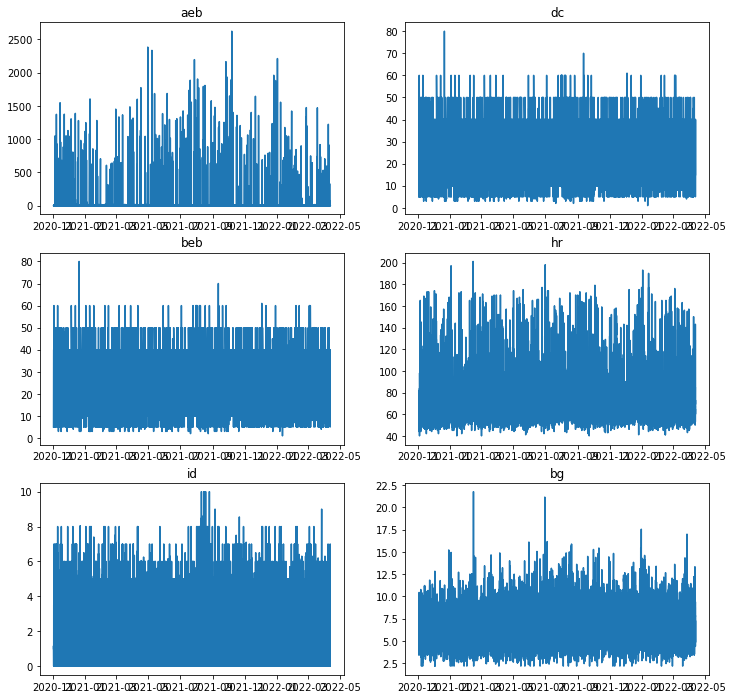

In [10]:
fig, axs = plt.subplots(3,2, figsize=(12,12))
for i, key in enumerate(fields.keys()):
    print(i, key)
    tmp = ds[key]
    axs[i%3,i//3].plot(tmp["value"].apply(myfloat).sort_index())
    axs[i%3,i//3].set_title(key)

plt.show()

In [11]:
#ti = pd.date_range(start="2018-01-01", end="2018-01-02", freq="H")
#n = len(ti)

def distribute_interval(value, start, end, freq):
    ti = pd.date_range(start=start, end=end, freq=freq)
    n = len(ti) 
    return pd.DataFrame(np.ones(n)*value/n, index=ti, columns=["value"])

#distribute_interval(75., start="2018-01-01", end="2018-01-02", freq="min")

#for idx, row in df.head().iterrows():
#    print(row["startDate"],row["endDate"],row["value"])
    
def expand_intervals(df_):
    if len(df_)==0:
        return None
    temp = [distribute_interval(row["value"], row["startDate"],row["endDate"], freq="min") 
               for idx, row in df_.iterrows()]
    return pd.concat(temp)

#tst = ds["id"].tail(5)
#print(tst["value"].head())

#tmp = expand_intervals(tst)
#print(tmp.head())

#start = tmp.index[0]
#print(start)

#val = tmp.resample('5min').sum() # , origin='2022-02-06 04:53:00'
#print("val", val.sum(), tmp.sum())
#print(val.head())

#fig, axs = plt.subplots(1,2, figsize=(12,4))
#axs[0].plot(tmp, '.')
#axs[1].plot(val, '.')
#plt.show()

#del tmp, tst, val, start


In [12]:
ds["eb"] = pd.concat([expand_intervals(ds["aeb"]),expand_intervals(ds["beb"])]).sort_index()
print("eb:", ds["eb"]["value"].sum(), ds["aeb"]["value"].sum()+ds["beb"]["value"].sum())

ds["ia"] = expand_intervals(ds["id"]).sort_index()
print("ia:", ds["ia"]["value"].sum(), ds["id"]["value"].sum())


eb: 764247.7702 764247.7702000095
ia: 25591.351021947285 25591.351021947357


In [13]:
start = T0 # ds["bg"].index[0]
start


Timestamp('2020-11-02 00:03:13')

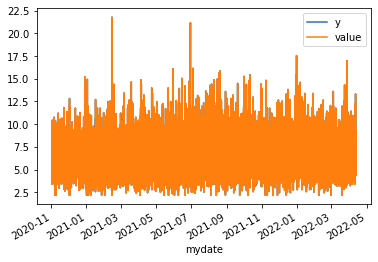

In [14]:
ts = ds["bg"]["value"].apply(myfloat).resample('5min', origin=start).mean()
ts = pd.DataFrame(ts)
ts.columns=["y"]
ts.head()
ts["y"].plot()
ds["bg"]["value"].plot()
plt.legend()
plt.show()

764247.1682000001 764247.7702


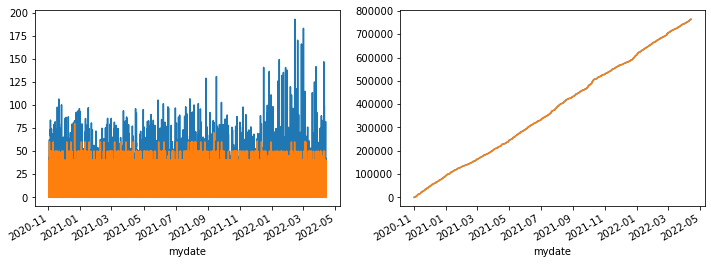

In [15]:
ts["a"] = ds["eb"]["value"].fillna(0).resample('5min', origin=start).sum()
ts["a"] = ts["a"].fillna(0)
print(ts["a"].sum(), ds["eb"]["value"].sum())
fig, axs = plt.subplots(1,2,figsize=(12,4))
ts["a"].plot(ax=axs[0])
ds["eb"]["value"].plot(ax=axs[0])
ts["a"].cumsum().plot(ax=axs[1])
ds["eb"]["value"].cumsum().plot(ax=axs[1])
plt.show()
#ts.head()



25591.35102194727 25591.351021947285


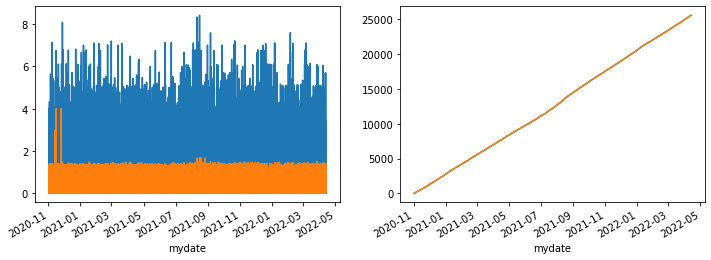

In [16]:
ts["b"] = ds["ia"]["value"].fillna(0).resample('5min', origin=start).sum()
ts["b"] = ts["b"].fillna(0)
print(ts["b"].sum(), ds["ia"]["value"].sum())
fig, axs = plt.subplots(1,2,figsize=(12,4))
ts["b"].plot(ax=axs[0])
ds["ia"]["value"].plot(ax=axs[0])
ts["b"].cumsum().plot(ax=axs[1])
ds["ia"]["value"].cumsum().plot(ax=axs[1])
plt.show()
#ts.head()


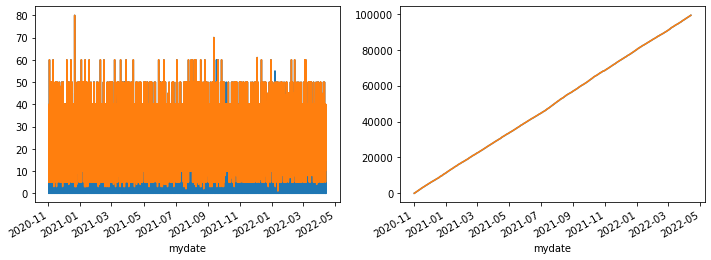

In [17]:
ts["c"] = ds["dc"]["value"].resample('5min', origin=start).sum()
ts["c"] = ts["c"].fillna(0)
fig, axs = plt.subplots(1,2,figsize=(12,4))
ts["c"].plot(ax=axs[0])
ds["dc"]["value"].plot(ax=axs[0])
ts["c"].cumsum().plot(ax=axs[1])
ds["dc"]["value"].cumsum().plot(ax=axs[1])
plt.show()
#ts.tail()


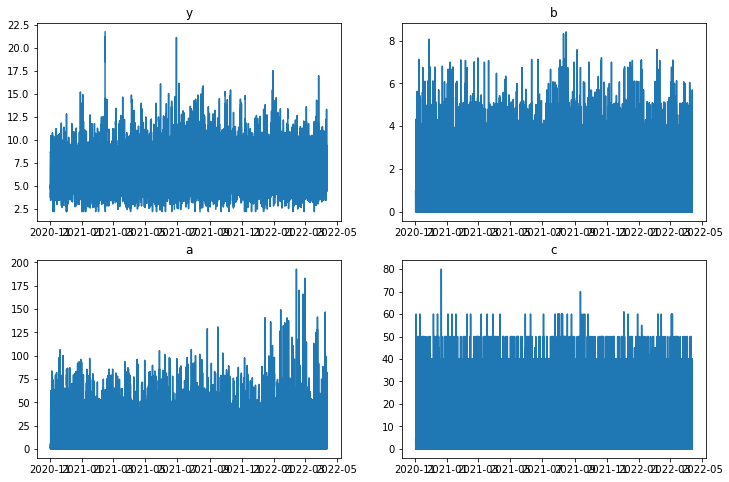

In [18]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
for i, key in enumerate(ts.columns):
    #print(i, key)
    axs[i%2,i//2].plot(ts[key])
    axs[i%2,i//2].set_title(key)
plt.show()

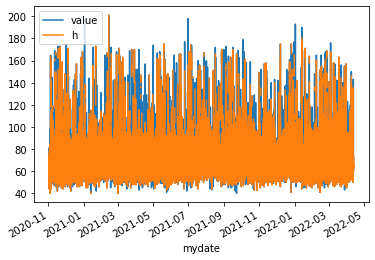

In [19]:
def dropidxdup(df3):
    return df3[~df3.index.duplicated(keep='first')]

ts["h"] = dropidxdup(ds["hr"]["value"]).resample('5min', origin=start).mean()
if len(ds["hr"]) > 0:
    ds["hr"]["value"].plot()
ts["h"].plot()
plt.legend()
plt.show()

In [20]:
ts.describe().T

,count,mean,std,min,25%,50%,75%,max
y,148688.0,6.450520,1.875935,2.16479,5.10669,6.161330,7.493510,21.758900
a,151764.0,5.035761,13.420839,0.00000,0.00000,0.996000,3.128000,192.893043
b,151764.0,0.168626,0.494799,0.00000,0.00000,0.064837,0.115702,8.416030
c,151764.0,0.653877,4.508887,0.00000,0.00000,0.000000,0.000000,80.000000
h,59382.0,67.837966,14.436426,40.00000,59.00000,65.000000,73.000000,201.000000


In [21]:
ts.to_csv("ah%i_long.csv"%(bd_id))


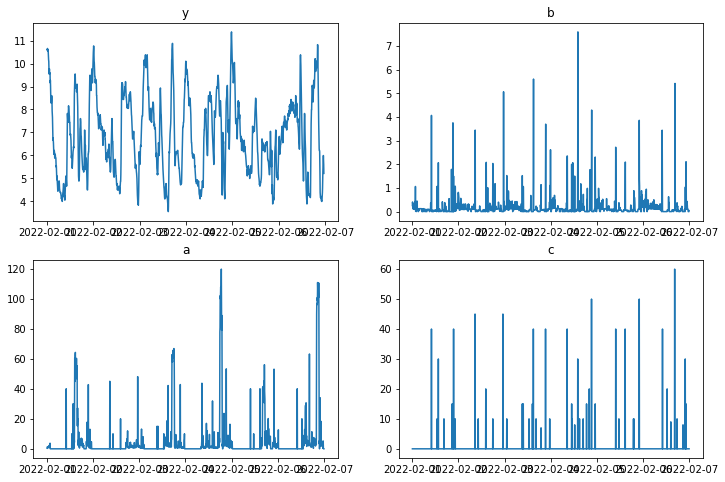

,count,mean,std,min,25%,50%,75%,max
y,1721.0,6.881155,1.702980,3.55248,5.495240,6.771910,8.159600,11.379000
a,1728.0,4.980782,15.931493,0.00000,0.000000,0.000000,2.281750,119.741303
b,1728.0,0.172353,0.469994,0.00000,0.014855,0.079584,0.124309,7.592103
c,1728.0,0.597222,4.330823,0.00000,0.000000,0.000000,0.000000,60.000000
h,544.0,65.412615,11.162462,48.00000,57.000000,63.000000,71.148305,141.000000


In [24]:
# week

if bd_id == 25:
    ws = ts[ts.index>pd.to_datetime("2021-02-01")]
    ws = ws[ws.index<pd.to_datetime("2021-02-07")]

if bd_id == 78:
    ws = ts[ts.index>pd.to_datetime("2022-02-01")]
    ws = ws[ws.index<pd.to_datetime("2022-02-07")]


ws.to_csv("ah%i_week.csv"%(bd_id))

fig, axs = plt.subplots(2,2, figsize=(12,8))
for i, key in enumerate(["y","a","b","c"]):
    #print(i, key)
    axs[i%2,i//2].plot(ws[key])
    axs[i%2,i//2].set_title(key)
plt.show()

ws.describe().T


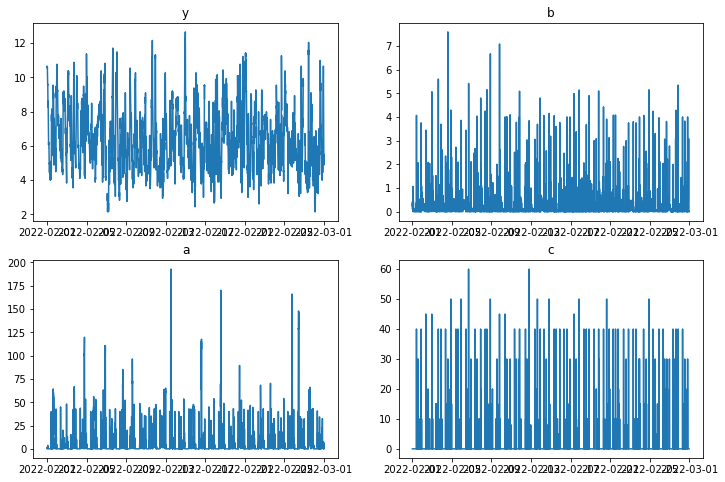

,count,mean,std,min,25%,50%,75%,max
y,1721.0,6.881155,1.702980,3.55248,5.495240,6.771910,8.159600,11.379000
a,1728.0,4.980782,15.931493,0.00000,0.000000,0.000000,2.281750,119.741303
b,1728.0,0.172353,0.469994,0.00000,0.014855,0.079584,0.124309,7.592103
c,1728.0,0.597222,4.330823,0.00000,0.000000,0.000000,0.000000,60.000000
h,544.0,65.412615,11.162462,48.00000,57.000000,63.000000,71.148305,141.000000


In [25]:
# month

if bd_id == 25:
    ms = ts[ts.index>pd.to_datetime("2021-02-01")]
    ms = ms[ms.index<pd.to_datetime("2021-03-01")]

if bd_id == 78:
    ms = ts[ts.index>pd.to_datetime("2022-02-01")]
    ms = ms[ms.index<pd.to_datetime("2022-03-01")]


ms.to_csv("ah%i_month.csv"%(bd_id))

fig, axs = plt.subplots(2,2, figsize=(12,8))
for i, key in enumerate(["y","a","b","c"]):
    #print(i, key)
    axs[i%2,i//2].plot(ms[key])
    axs[i%2,i//2].set_title(key)
plt.show()

ws.describe().T

